# Métodos para la generación de datos sintéticos

**Máster universitario en Ciencia de Datos (MUCD) - CUNEF**    

**Autor: Antonio Tello Gómez** 
**Tutor: Diego J. Bodas Sagui**  
**Fecha:  29/03/2022**


![cunef](https://live.staticflickr.com/2588/4171571040_bab4a40acf_z.jpg)

# 1. Demostración datos sintéticos con Iris  
**(1.0-synth-data-demo.ipynb)**

![iris](https://machinelearninghd.com/wp-content/uploads/2021/03/iris-dataset.png)

In [1]:
#Librerias
%load_ext autotime
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

#Synthetic Data
#SDV
from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN, TVAE
from sdv.evaluation import evaluate
import sdv
#Synthia
import xarray as xr
import synthia as syn
#import pyvinecopulib as pv
from table_evaluator import TableEvaluator



#ML 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

from lightgbm import LGBMClassifier, plot_importance
 
import warnings
warnings.filterwarnings('ignore')

time: 2.03 s (started: 2022-06-05 10:45:08 +02:00)


In [ ]:
# Lectura de datos
#df = pd.read_csv("https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv")
df = sns.load_dataset("iris")

In [ ]:
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


time: 15.1 ms (started: 2022-06-04 17:58:31 +02:00)


In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['variety'])
print(f"Train size: {len(train)},", f"Test size: {len(test)}")

Train size: 120, Test size: 30
time: 4.3 ms (started: 2022-06-04 17:58:31 +02:00)


## Metadatos Tabla

Los metadatos de la tabla son una parte fundamental de la librería SDV. Ya que son estos metadatos los que contienen toda la inofrmación de la tabla necesaria para el generador. 
https://sdv.dev/SDV/developer_guides/sdv/metadata.html

Una alternativa a crear un fichero Json de cero con todos los metadatos de la tabla es especificar los tipos de los campos y los transformers que queremos aplicar. Y posteriormente extraer el objeto metadatos del modelo. 

In [ ]:
field_types=  {
                "sepal.length": {
                    "type" : "numerical",
                    "subtype" : "float"
                    },
                "sepal.width":  {
                    "type" : "numerical",
                    "subtype" : "float"
                    },
                "petal.length": {
                    "type":"numerical",
                    "subtype":"float"
                            },
                "petal_width": {
                    "type":"numerical",
                    "subtype":"float"
                            },
                "variety": {
                    "type": "categorical"
                            }
}

time: 913 µs (started: 2022-06-04 17:58:31 +02:00)


## Generadores

### Gaussian Copula
https://github.com/sdv-dev/Copulas

In [ ]:
gaussian_copula = GaussianCopula(field_types=field_types)

time: 524 µs (started: 2022-06-04 17:58:31 +02:00)


In [ ]:
gaussian_copula.fit(train)

time: 1.12 s (started: 2022-06-04 17:58:31 +02:00)


In [ ]:
np.random.seed(2022)
synthetic_data_gc = gaussian_copula.sample(len(df)*3)

time: 13.7 ms (started: 2022-06-04 17:58:33 +02:00)


In [ ]:
# Ejemplo
gaussian_copula.sample(6)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,6.9,3.5,4.2,2.0,Setosa
1,4.4,2.4,1.2,0.3,Setosa
2,5.9,2.9,5.7,2.0,Virginica
3,5.9,3.0,4.9,1.8,Versicolor
4,5.7,3.3,2.8,0.4,Setosa
5,5.5,3.1,3.5,1.3,Versicolor


time: 19.5 ms (started: 2022-06-04 17:58:33 +02:00)


In [ ]:
# Distribución marginal de cada columna 
gaussian_copula.get_distributions()

{'sepal.length.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'sepal.width.value': 'copulas.univariate.gamma.GammaUnivariate',
 'petal.length.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'petal.width.value': 'copulas.univariate.beta.BetaUnivariate',
 'variety.value': 'copulas.univariate.uniform.UniformUnivariate'}

time: 2.91 ms (started: 2022-06-04 17:58:33 +02:00)


#### Metadata

A partir del modelo ajustado podemos extraer un objeto de metadatos completo al cual podemos añadir información interesante como campos sensibles o la variable target

In [ ]:
table_metadata = gaussian_copula.get_metadata().to_dict()
table_metadata['target'] = 'variety'
table_metadata['name'] = 'iris'
table_metadata['key_fields'] = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
table_metadata['sensitive_fields'] = ['variety']
#metadata = sdv.metadata.Table.from_dict(metadata)
metadata = {'tables': 
    {'iris': table_metadata}}
metadata = sdv.metadata.dataset.Metadata(metadata)

time: 1.34 ms (started: 2022-06-04 17:58:33 +02:00)


In [ ]:
metadata.get_fields('iris')

{'sepal.length': {'type': 'numerical',
  'subtype': 'float',
  'transformer': 'float'},
 'sepal.width': {'type': 'numerical',
  'subtype': 'float',
  'transformer': 'float'},
 'petal.length': {'type': 'numerical',
  'subtype': 'float',
  'transformer': 'float'},
 'petal.width': {'type': 'numerical',
  'subtype': 'float',
  'transformer': 'float'},
 'variety': {'type': 'categorical', 'transformer': 'categorical_fuzzy'}}

time: 3.4 ms (started: 2022-06-04 17:58:33 +02:00)


### CTGAN
https://github.com/sdv-dev/CTGAN

In [ ]:
ctgan = CTGAN(verbose=False, table_metadata=table_metadata)

time: 824 µs (started: 2022-06-04 17:58:33 +02:00)


In [ ]:
ctgan.fit(train)

time: 7.76 s (started: 2022-06-04 17:58:33 +02:00)


In [ ]:
ctgan.get_metadata()

Table(name=iris, field_names=['sepal.length', 'sepal.width', 'petal.length', 'petal.width', 'variety'])

time: 1.97 ms (started: 2022-06-04 17:58:41 +02:00)


In [ ]:
#Ejemplo 
ctgan.sample(6)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.6,4.4,1.2,1.6,Versicolor
1,7.7,4.3,6.9,2.0,Setosa
2,6.2,3.2,6.9,1.6,Setosa
3,7.9,3.4,5.4,0.7,Setosa
4,7.9,2.6,2.0,0.6,Virginica
5,6.6,3.2,6.0,1.3,Setosa


time: 31.5 ms (started: 2022-06-04 17:58:41 +02:00)


In [ ]:
np.random.seed(2022)
synthetic_data_ctgan = ctgan.sample(len(df)*3)

time: 24.9 ms (started: 2022-06-04 17:58:42 +02:00)


### CopulaGAN

In [ ]:
copgan = CopulaGAN(verbose=False,table_metadata=table_metadata)

time: 859 µs (started: 2022-06-04 17:58:42 +02:00)


In [ ]:
copgan.fit(train)

time: 5.64 s (started: 2022-06-04 17:58:42 +02:00)


In [ ]:
copgan.sample(6)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,4.3,4.0,1.3,2.0,Virginica
1,5.8,4.1,5.4,2.5,Setosa
2,6.5,4.2,2.0,0.1,Virginica
3,6.3,4.4,4.7,0.4,Versicolor
4,4.7,4.1,1.2,1.8,Versicolor
5,4.6,3.7,1.3,2.1,Setosa


time: 31.7 ms (started: 2022-06-04 17:58:48 +02:00)


In [ ]:
np.random.seed(2022)
synthetic_data_copgan = copgan.sample(len(df)*3)

time: 27.9 ms (started: 2022-06-04 17:58:48 +02:00)


In [ ]:
# Distribución marginal de cada columna 
gaussian_copula.get_distributions()

{'sepal.length.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'sepal.width.value': 'copulas.univariate.gamma.GammaUnivariate',
 'petal.length.value': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'petal.width.value': 'copulas.univariate.beta.BetaUnivariate',
 'variety.value': 'copulas.univariate.uniform.UniformUnivariate'}

time: 2.8 ms (started: 2022-06-04 17:58:48 +02:00)


### TVAE

In [ ]:
tvae = TVAE(table_metadata=table_metadata)

time: 517 µs (started: 2022-06-04 17:58:48 +02:00)


In [ ]:
tvae.fit(train)

time: 3.32 s (started: 2022-06-04 17:58:48 +02:00)


In [ ]:
tvae.sample(6)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.6,3.1,5.1,1.8,Virginica
1,6.1,3.1,5.0,1.8,Versicolor
2,6.1,3.4,4.7,1.8,Versicolor
3,5.8,2.3,4.0,1.5,Versicolor
4,6.5,3.0,4.8,1.9,Versicolor
5,6.1,3.0,4.8,1.5,Virginica


time: 53.8 ms (started: 2022-06-04 17:58:52 +02:00)


In [ ]:
np.random.seed(2022)
synthetic_data_tvae = tvae.sample(len(df)*3)

time: 39.5 ms (started: 2022-06-04 17:58:52 +02:00)


### fPCA
https://github.com/dmey/synthia

#### Reversible Data Transform (RDT)
https://github.com/sdv-dev/RDT

In [ ]:
from rdt import HyperTransformer
ht = HyperTransformer(field_types)

time: 417 µs (started: 2022-06-04 17:58:52 +02:00)


In [ ]:
ht.fit(df)

time: 10.1 ms (started: 2022-06-04 17:58:52 +02:00)


In [ ]:
transformed = ht.transform(df,)
transformed

,sepal.length.value,sepal.width.value,petal.length.value,petal.width.value,variety.value
0,5.1,3.5,1.4,0.2,0.186152
1,4.9,3.0,1.4,0.2,0.145225
2,4.7,3.2,1.3,0.2,0.214170
3,4.6,3.1,1.5,0.2,0.184541
4,5.0,3.6,1.4,0.2,0.145522
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0.929534
146,6.3,2.5,5.0,1.9,0.898729
147,6.5,3.0,5.2,2.0,0.868394
148,6.2,3.4,5.4,2.3,0.843415


time: 15.4 ms (started: 2022-06-04 17:58:52 +02:00)


In [ ]:
fpca = syn.FPCADataGenerator()
fpca.fit(transformed, n_fpca_components=3)

time: 5.04 ms (started: 2022-06-04 17:58:52 +02:00)


In [ ]:
np.random.seed(2022)
synthetic_data_fpca = fpca.generate(n_samples=len(df)*3)
synthetic_data_fpca = pd.DataFrame(synthetic_data_fpca, columns=['sepal.length.value','sepal.width.value','petal.length.value','petal.width.value','variety.value'])
synthetic_data_fpca = ht.reverse_transform(synthetic_data_fpca)
synthetic_data_fpca.tail()

,sepal.length,sepal.width,petal.length,petal.width,variety
445,6.593451,2.265156,6.812834,2.495833,Virginica
446,4.817827,3.939312,1.469252,0.550746,Setosa
447,5.044853,3.655239,1.489526,0.343998,Setosa
448,6.743126,3.004109,5.962245,2.205338,Virginica
449,6.216369,2.427489,4.456215,1.215668,Versicolor


time: 25.5 ms (started: 2022-06-04 17:58:52 +02:00)


### Gaussian Copula (Synthia) 

In [ ]:
parameterizer = syn.QuantileParameterizer(n_quantiles=100)
gcs = syn.CopulaDataGenerator()
gcs.fit(transformed, copula=syn.GaussianCopula(), parameterize_by=parameterizer)

time: 5.59 ms (started: 2022-06-04 17:58:52 +02:00)


In [ ]:
np.random.seed(2022)
synthetic_data_gcs = gcs.generate(n_samples=len(df)*3)
synthetic_data_gcs = pd.DataFrame(synthetic_data_gcs, columns=['sepal.length.value','sepal.width.value','petal.length.value','petal.width.value','variety.value'])
synthetic_data_gcs = ht.reverse_transform(synthetic_data_gcs)
synthetic_data_gcs.tail()

,sepal.length,sepal.width,petal.length,petal.width,variety
445,6.087749,3.400000,4.408432,1.400000,Virginica
446,5.719166,2.700000,4.218621,1.448207,Versicolor
447,5.197813,2.864845,4.903190,1.403452,Versicolor
448,5.400000,3.400000,3.904477,0.200000,Setosa
449,4.600000,2.337635,1.400000,0.100000,Setosa


time: 33.7 ms (started: 2022-06-04 17:58:53 +02:00)


### VineCopula

In [ ]:
parameterizer = syn.QuantileParameterizer(n_quantiles=100)
vc = syn.CopulaDataGenerator()
vc.fit(transformed, copula=syn.VineCopula(), parameterize_by=parameterizer)

time: 2.11 s (started: 2022-06-04 17:58:53 +02:00)


In [ ]:
np.random.seed(2022)
synthetic_data_vc = vc.generate(n_samples=len(df)*3)
synthetic_data_vc = pd.DataFrame(synthetic_data_vc, columns=['sepal.length.value','sepal.width.value','petal.length.value','petal.width.value','variety.value'])
synthetic_data_vc = ht.reverse_transform(synthetic_data_vc)
synthetic_data_vc.tail()

,sepal.length,sepal.width,petal.length,petal.width,variety
445,6.401098,3.000000,5.382482,2.300000,Virginica
446,5.796714,2.300445,5.264843,2.000000,Virginica
447,6.492061,2.700000,5.513611,1.800000,Versicolor
448,4.587110,2.800000,1.405816,0.186422,Setosa
449,7.681961,2.300000,6.452789,2.302763,Virginica


time: 27.3 ms (started: 2022-06-04 17:58:55 +02:00)


## Evaluación



### Evaluation Metrics

El paquete SDMetrics parte también de SDV ofrece un framework para evaluar generadores de datos sintéticos que pretende ser un benchmark para la comparabilidad objetiva independientmente del caso y dataset.  
Incluye en una sola métrica:
- Statistical metrics which use statistical tests to compare the distributions of the real and synthetic distributions.
- Detection metrics which use machine learning to try to distinguish between real and synthetic data.
- Efficacy metrics which compare the performance of machine learning models when run on the synthetic and real data.
- Bayesian Network and Gaussian Mixture metrics which learn the distribution of the real data and evaluate the likelihood of the synthetic data belonging to the learned distribution.
- Privacy metrics which evaluate whether the synthetic data is leaking information about the real data.

In [ ]:
synth_data = [synthetic_data_gc,synthetic_data_ctgan,synthetic_data_copgan,synthetic_data_tvae, synthetic_data_fpca, synthetic_data_gcs, synthetic_data_vc]

time: 401 µs (started: 2022-06-04 17:58:55 +02:00)


In [ ]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

time: 441 µs (started: 2022-06-04 17:58:55 +02:00)


In [ ]:
for dataset in synth_data:
    print(f"Overall Score {get_df_name(dataset)}:",evaluate(dataset, df, metadata, table_name='iris'))

Overall Score synthetic_data_gc: 0.7120548330115664
Overall Score synthetic_data_ctgan: 0.3726412912415277
Overall Score synthetic_data_copgan: 0.32790384174071907
Overall Score synthetic_data_tvae: 0.7958092608562766
Overall Score synthetic_data_fpca: 0.8284102085388252
Overall Score synthetic_data_gcs: 0.7752424203110654
Overall Score synthetic_data_vc: 0.7993455231208528
time: 23.9 s (started: 2022-06-04 17:58:55 +02:00)


vamos a examinar más en detalle el modelo VineCopula

In [ ]:
ev = evaluate(synthetic_data_vc, df,metadata,aggregate=False,table_name='iris')
ev

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,BNLogLikelihood,BayesianNetwork Log Likelihood,NaN,NaN,-inf,0.0,MAXIMIZE,Please install pomegranate with `pip install p...
1,LogisticDetection,LogisticRegression Detection,1.000000,1.000000,0.0,1.0,MAXIMIZE,None
2,SVCDetection,SVC Detection,0.616356,0.616356,0.0,1.0,MAXIMIZE,None
3,BinaryDecisionTreeClassifier,None,0.844444,0.844444,0.0,1.0,MAXIMIZE,None
4,BinaryAdaBoostClassifier,None,0.960000,0.960000,0.0,1.0,MAXIMIZE,None
5,BinaryLogisticRegression,None,1.000000,1.000000,0.0,1.0,MAXIMIZE,None
6,BinaryMLPClassifier,None,1.000000,1.000000,0.0,1.0,MAXIMIZE,None
7,MulticlassDecisionTreeClassifier,None,0.730290,0.730290,0.0,1.0,MAXIMIZE,None
8,MulticlassMLPClassifier,None,0.898787,0.898787,0.0,1.0,MAXIMIZE,None
9,LinearRegression,None,NaN,NaN,-inf,1.0,MAXIMIZE,could not convert string to float: 'Setosa'


time: 3.4 s (started: 2022-06-04 17:59:19 +02:00)


### Table Evaluator
https://github.com/Baukebrenninkmeijer/table-evaluator

In [ ]:
table_evaluator = TableEvaluator(df, synthetic_data_vc)

time: 14.3 ms (started: 2022-06-04 17:59:23 +02:00)


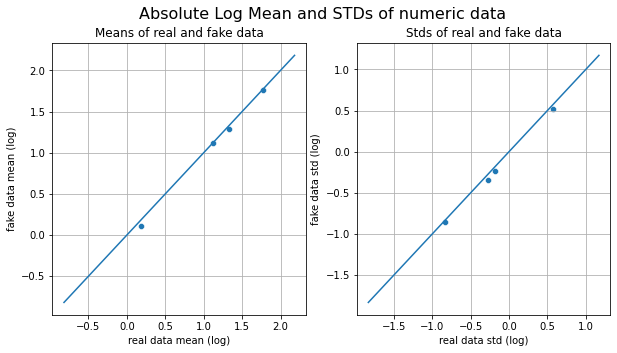

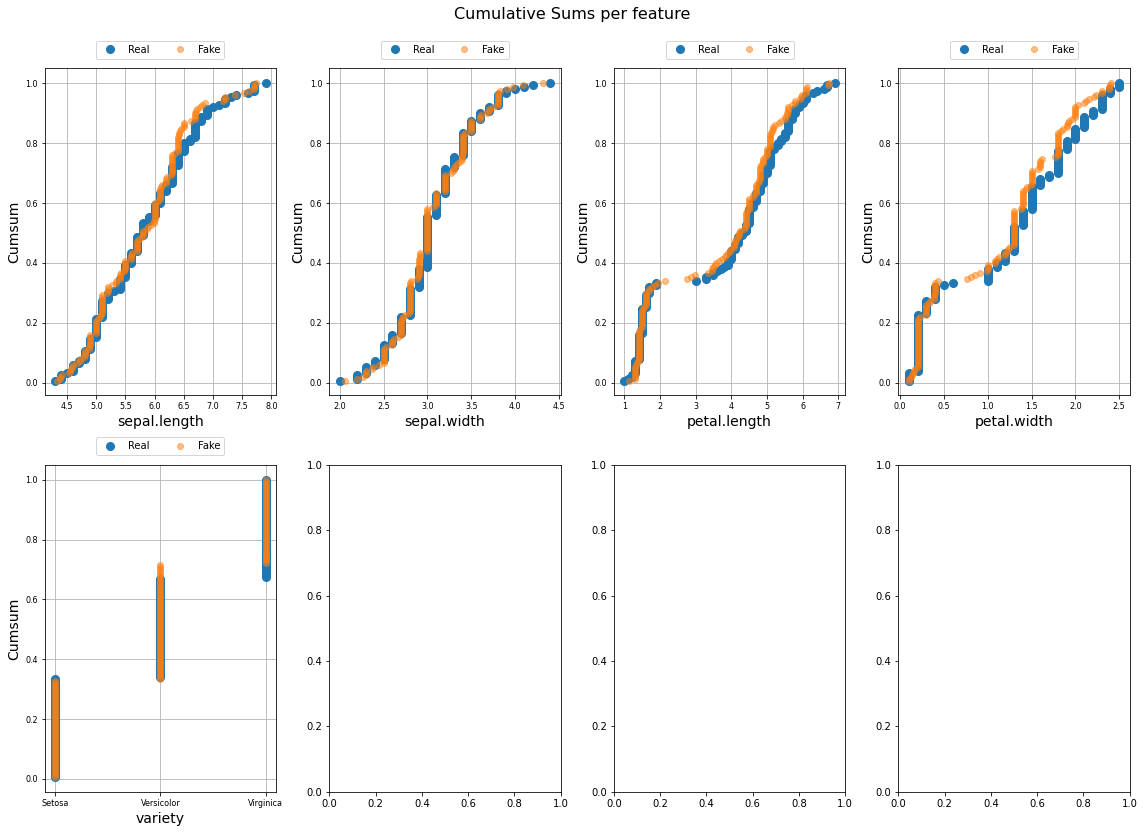

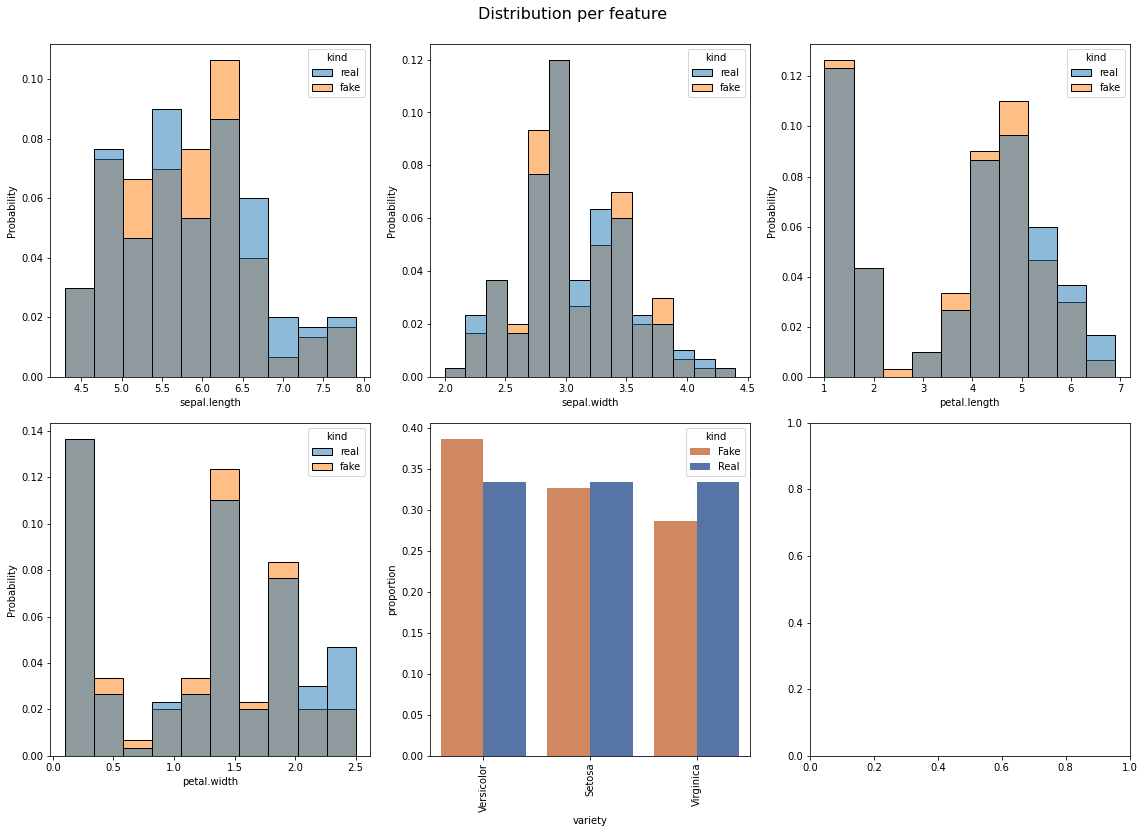

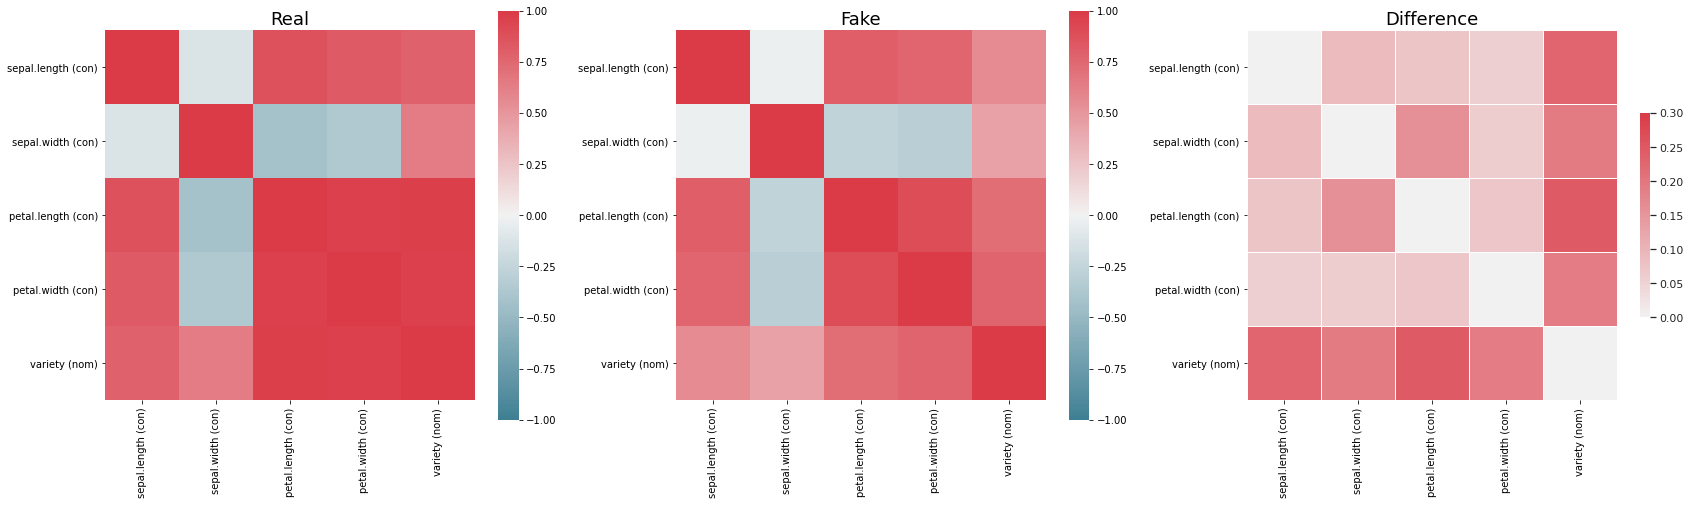

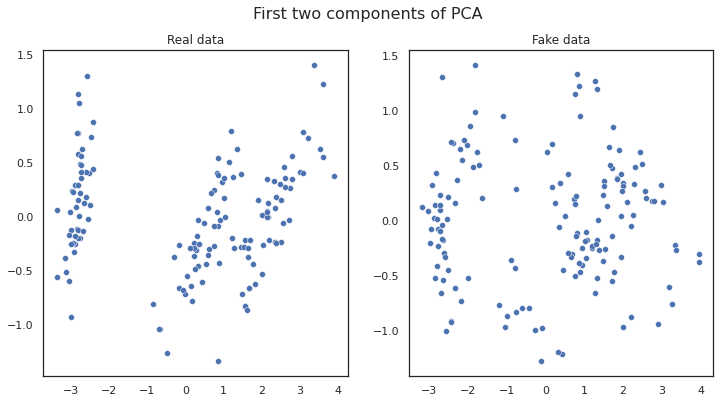

time: 4.29 s (started: 2022-06-04 17:59:23 +02:00)


In [ ]:
table_evaluator.visual_evaluation()

In [ ]:
table_evaluator.evaluate(target_col='variety', notebook=True)

## Kolmogorov-Smirnov statistic

,statistic,p-value,equality
col_name,,,
sepal.length,0.0867,0.6279,identical
sepal.width,0.0533,0.9839,identical
petal.length,0.0800,0.7250,identical
petal.width,0.0933,0.5322,identical


time: 6.32 s (started: 2022-06-04 17:59:27 +02:00)


### Plots

histograms, barplots, boxplots, feature importance

In [ ]:
def histograms_comparison(real_df, synthetic_df , col_name, isContinuous): 
    """
    Visualize a variable in real and synth data.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    sns.set_color_codes(palette='pastel')

    count_null = real_df[col_name].isnull().sum()
    
    if isContinuous:
        
        sns.histplot(real_df.loc[real_df[col_name].notnull(), col_name], kde=False, color='b', ax=ax1)
    else:
        sns.countplot(real_df[col_name], order=sorted(real_df[col_name].unique()), color='b', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)

    count_null = synthetic_df[col_name].isnull().sum()
    
    if isContinuous:
        
        sns.histplot(synthetic_df.loc[synthetic_df[col_name].notnull(), col_name], kde=False, color='red', ax=ax2)
    else:
        sns.countplot(synthetic_df[col_name], order=sorted(df[col_name].unique()), color='red', saturation=1, ax=ax2)
    ax2.set_xlabel(col_name)
    ax2.set_ylabel('Count')
    ax2.set_title('Synthetic '+col_name+ '  Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)

    
    plt.tight_layout()
    

time: 1.71 ms (started: 2022-06-04 17:59:34 +02:00)


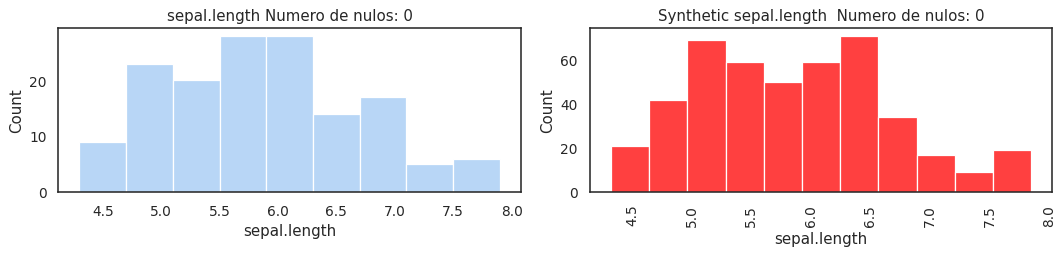

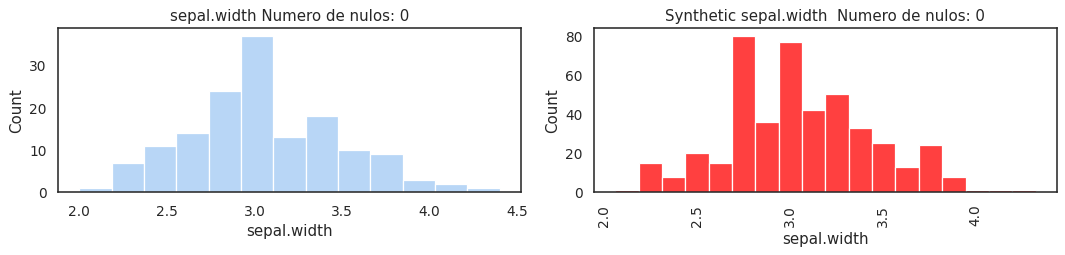

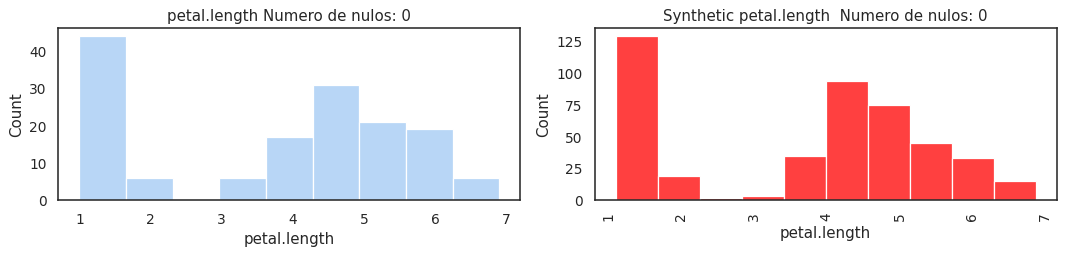

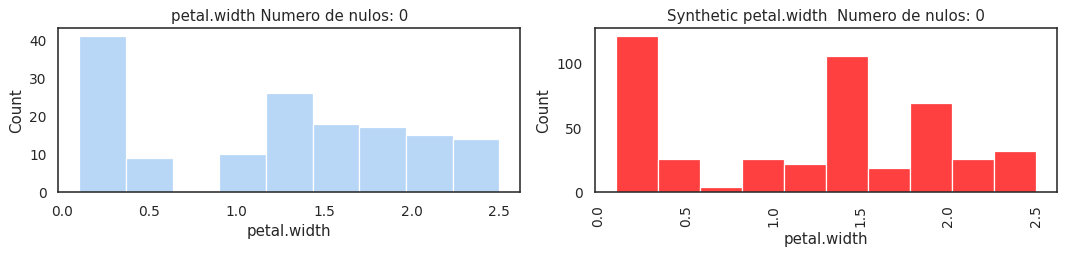

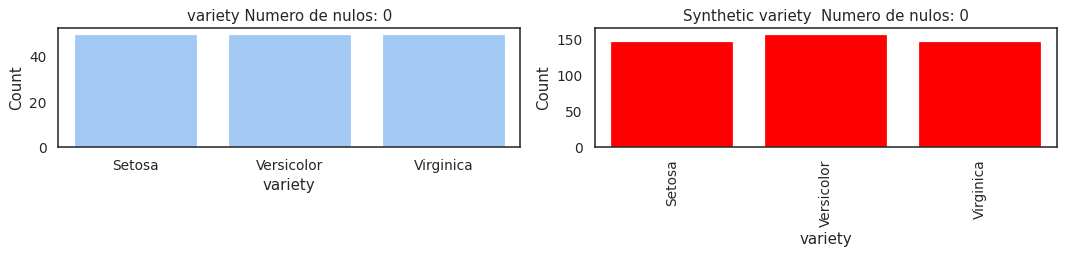

time: 2.26 s (started: 2022-06-04 17:59:34 +02:00)


In [ ]:
for i in list(df.columns):
    if (df[i].dtype==float):
        histograms_comparison(df,synthetic_data_vc,col_name=i, isContinuous=True)
    else:  
        histograms_comparison(df,synthetic_data_vc, col_name=i, isContinuous=False)

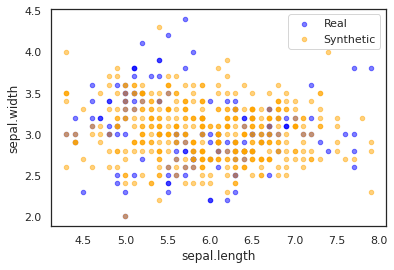

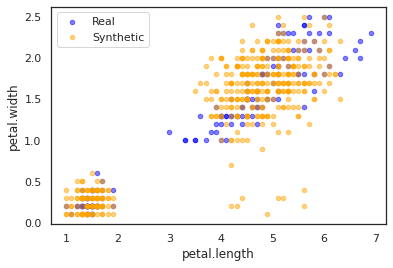

time: 454 ms (started: 2022-06-04 17:59:37 +02:00)


In [ ]:
from copulas.visualization import compare_3d, compare_2d


# Plot the real and the synthetic data to compare
compare_2d(df.iloc[:,0:2], synthetic_data_tvae.iloc[:,0:2])
compare_2d(df.iloc[:,2:4], synthetic_data_tvae.iloc[:,2:4])

## Eficacia para Modelado

### Datos Reales

#### Entreno

In [ ]:
xtrain =  train.drop(columns=['variety']) 
ytrain = train['variety']
xtest =  test.drop(columns=['variety']) 
ytest = test['variety']

time: 2.38 ms (started: 2022-06-04 17:59:37 +02:00)


In [ ]:
# numericas
numeric = list(xtrain.columns)
print(f"Numeirc :{numeric}")

Numeirc :['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
time: 1.01 ms (started: 2022-06-04 17:59:37 +02:00)


In [ ]:
#Pipelines    
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('clasificador', LGBMClassifier())])

time: 1.01 ms (started: 2022-06-04 17:59:37 +02:00)


In [ ]:
print('Training model...')
model.fit(xtrain,ytrain)
print("done!")

Training model...
done!
time: 5.2 s (started: 2022-06-04 17:59:37 +02:00)


#### Evaluación

In [ ]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, np.transpose([pred[:, 1] for pred in ypred_proba]), multi_class='ovo', average=None)))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

time: 644 µs (started: 2022-06-04 17:59:43 +02:00)


In [ ]:
ypred = model.predict(xtest)
evaluate_model(ytest,ypred)

Accuracy of the model: 0.9666666666666667

Classification report: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       0.91      1.00      0.95        10
   Virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion matrix: 
[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]

time: 9.51 ms (started: 2022-06-04 17:59:43 +02:00)


### Datos Sintéticos

In [ ]:
# Bucle para entrenar y evaluar lightgbm sobre todos los datos sintéticos
for data in synth_data:
    xtrain =  data.drop(columns=['variety']) 
    ytrain = data['variety']
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print(f"{evaluate_model(ytest,ypred)} ------------- {get_df_name(data)} -------------  ")

Accuracy of the model: 0.5666666666666667

Classification report: 
              precision    recall  f1-score   support

      Setosa       1.00      0.90      0.95        10
  Versicolor       0.36      0.40      0.38        10
   Virginica       0.40      0.40      0.40        10

    accuracy                           0.57        30
   macro avg       0.59      0.57      0.58        30
weighted avg       0.59      0.57      0.58        30


Confusion matrix: 
[[9 1 0]
 [0 4 6]
 [0 6 4]]

None ------------- synthetic_data_gc -------------  
Accuracy of the model: 0.43333333333333335

Classification report: 
              precision    recall  f1-score   support

      Setosa       0.40      0.40      0.40        10
  Versicolor       0.36      0.40      0.38        10
   Virginica       0.56      0.50      0.53        10

    accuracy                           0.43        30
   macro avg       0.44      0.43      0.44        30
weighted avg       0.44      0.43      0.44        30




## Conclusión

En este caso, con un dataset sencillo con tan solo 4 variables de tipo numérico los modelos más tradicionales han obtenido un mejor score y generan datos sintéticos de mejor calidad. Esto se puede deber a distintos factore. Principalmente, los datos son insuficientes para que las redes neuronales entrenen de forma efectiva y la distribución de las variables se puede aproximar sin demasiada dificultad por modelos más sencillos. 